In [1]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from SSIM_PIL import compare_ssim
from PIL import Image
import os

No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


In [2]:
def bgr2rgb(img):
    b,g,r = cv.split(img)
    return cv.merge([r,g,b])

In [3]:
def get_dark_channel_r(img, size):

    #norm_img = np.float64(img) / np.float64(atmosphere)
    b,g,r = cv.split(img)
    min_channel = cv.min(r,g)    # return the minimum along image - channel axis
    #print(min_channel.shape)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (size, size))
    dark = cv.erode(min_channel, kernel)
    #print(dark)
    return dark

def get_dark_channel_g(img, size):

    b,g,r = cv.split(img)
    min_channel = cv.min(g,b)    # return the minimum along image - channel axis
    #print(min_channel.shape)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (size, size))
    dark = cv.erode(min_channel, kernel)
    #print(dark)
    return dark

def get_dark_channel_b(img, size):

    b,g,r = cv.split(img)
    min_channel = cv.min(b,r)    # return the minimum along image - channel axis
    #print(min_channel.shape)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (size, size))
    dark = cv.erode(min_channel, kernel)
    #print(dark)
    return dark


In [4]:
def get_atmospheric_light(img, size, percent):
    m, n, _ = img.shape
    flat_img = img.reshape(m * n, 3)    #reshaped image to m*n rows and 3 columns
    flat_dark = dark.ravel() #flatten dark channel image
    count = math.ceil(m * n * percent / 100)   # 0.1 % pixels
    indices = np.argpartition(flat_dark, -count)[:-count]
    atmospheric_light = np.amax(np.take(flat_img, indices, axis=0), axis=0)  #take the max pixels
    return atmospheric_light



In [5]:
def get_transmission_r(img, atmosphere, size, omega, radius, epsilon):

    #omega: To preserve minor amounts of haze.
    #radius and epsilon: Parameters for  the guided filter.

    norm_img = np.float64(img) / np.float64(atmosphere)
    raw_transmission = (1 - omega * get_dark_channel_r(norm_img, size=15)).astype(np.float32)
    transmission = cv.ximgproc.guidedFilter(img, raw_transmission, radius, epsilon)
    return transmission


def get_transmission_g(img, atmosphere, size, omega, radius, epsilon):

    #omega: To preserve minor amounts of haze.
    #radius and epsilon: Parameters for  the guided filter.

    norm_img = np.float64(img) / np.float64(atmosphere)
    raw_transmission = (1 - omega * get_dark_channel_g(norm_img, size=15)).astype(np.float32)
    transmission = cv.ximgproc.guidedFilter(img, raw_transmission, radius, epsilon)
    return transmission

def get_transmission_b(img, atmosphere, size, omega, radius, epsilon):

    #omega: To preserve minor amounts of haze.
    #radius and epsilon: Parameters for  the guided filter.

    norm_img = np.float64(img) / np.float64(atmosphere)
    raw_transmission = (1 - omega * get_dark_channel_b(norm_img, size=15)).astype(np.float32)
    transmission = cv.ximgproc.guidedFilter(img, raw_transmission, radius, epsilon)
    return transmission


In [6]:
def get_scene_radiance(img):
    
    trans_lb=0.1   #Lower bound for transmission
    omega=0.95
    L = 256
    clamped = np.clip(trans, trans_lb, omega)[:, :, None]    #to bound the transmission value
    img = np.float64(img)
    J = np.uint8(((img - atmosphere) / clamped + atmosphere).clip(0, L - 1))
    cv.imwrite("D:/IIIT/Research_Work/Image Dehazing/code/J_dehazed_img_final_rgb.png", cv.cvtColor(J, cv.COLOR_RGB2BGR))
    return J

MSE = 86.98645
PSNR = 11.15441
SSIM = 0.60011


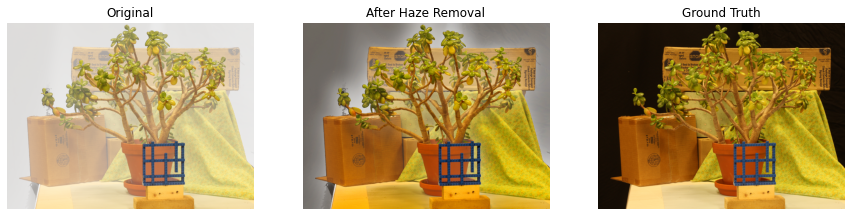

In [26]:
img = bgr2rgb(cv.imread("D:/IIIT/Research_Work/Image Dehazing/code/data/1000/hazy/20.png"))
ground_truth = cv.imread("D:/IIIT/Research_Work/Image Dehazing/code/data/1000/truth/20.png")
ground_truth_img = Image.open("D:/IIIT/Research_Work/Image Dehazing/code/data/1000/truth/20.png")
dark_r = get_dark_channel_r(img, size=15)
dark_g = get_dark_channel_g(img, size=15)
dark_b = get_dark_channel_b(img, size=15)
dark = trans = np.mean([dark_r,dark_g,dark_b], axis=0)
atmosphere = get_atmospheric_light(img, size=15, percent=0.1)
trans_r = get_transmission_r(img, atmosphere, size=15, omega=0.90, radius=40, epsilon=0.001)
trans_g = get_transmission_g(img, atmosphere, size=15, omega=0.90, radius=40, epsilon=0.001)
trans_b = get_transmission_b(img, atmosphere, size=15, omega=0.90, radius=40, epsilon=0.001)
trans = np.mean([trans_r,trans_g,trans_b], axis=0)
dehazed = get_scene_radiance(img)
f, (ax1, ax2,ax3) = plt.subplots(1, 3,  figsize=(15,15))
ax1.imshow(img)
ax1.set_title("Original")
ax1.axis('off')
ax2.imshow(dehazed)
ax2.set_title("After Haze Removal")
ax2.axis('off')
ax3.imshow(ground_truth[...,::-1])
ax3.set_title("Ground Truth")
ax3.axis('off')
Dehazed_img = Image.open("D:/IIIT/Research_Work/Image Dehazing/code/J_dehazed_img_final_rgb.png")
dehazed_img = cv.imread('D:/IIIT/Research_Work/Image Dehazing/code/J_dehazed_img_final_rgb.png')
ssim = compare_ssim(ground_truth_img, Dehazed_img)
mse = np.square(np.subtract(ground_truth,dehazed_img)).mean()
psnr = cv.PSNR(ground_truth, dehazed_img)
print("MSE =","{:.5f}".format(mse))
print("PSNR =","{:.5f}".format(psnr))
print("SSIM =","{:.5f}".format(ssim))